## Notebook for Running Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

## Experiments

### Prepare Test Harness

In [3]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [4]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

<IPython.core.display.Javascript object>

## Run Experiments

In [5]:
# baseline experiment
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

# topline experiment
topline = ToplineExperiment(
    model=model, dataset=CT_dataset, k=10, param_grid=param_grid
)
topline.run()

# method 2 experiment
uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

# method 3 experiment
uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2.run()

# method 4 experiment (sensitivity = 1)
margin_threshold_1 = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold_1.run()

# method 4 experiment (sensitivity = 2)
margin_threshold_2 = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=2,
)
margin_threshold_2.run()

<IPython.core.display.Javascript object>

## Plot Experimental Results

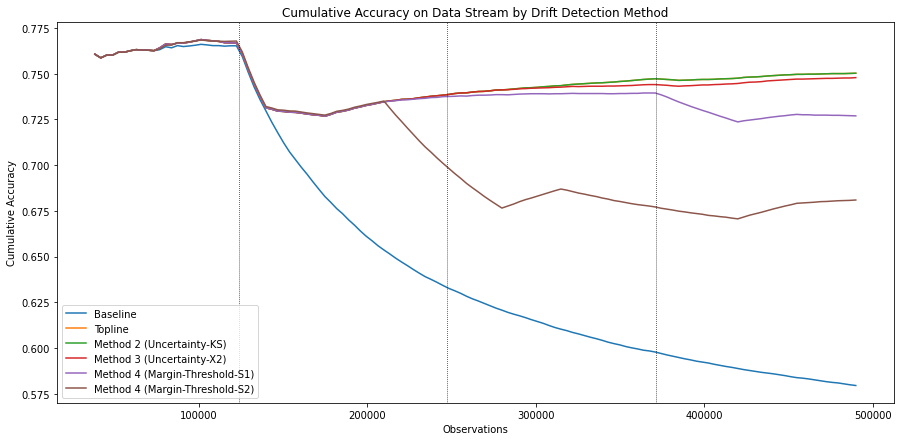

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
Baseline,0,0,0,0,0.0707,0.5795,0.11
Topline,13,3,10,0,0.9896,0.7502,1.47
Method 2 (Uncertainty-KS),13,3,10,0,0.9896,0.7502,1.51
Method 3 (Uncertainty-X2),10,6,4,0,0.7776,0.7478,1.24
Method 4 (Margin-Threshold-S1),5,6,2,3,0.4241,0.7269,0.72
Method 4 (Margin-Threshold-S2),4,11,0,7,0.3534,0.6809,0.56


<IPython.core.display.Javascript object>

In [6]:
exps = [
    baseline,
    topline,
    uncertainty_ks,
    uncertainty_x2,
    margin_threshold_1,
    margin_threshold_2,
]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

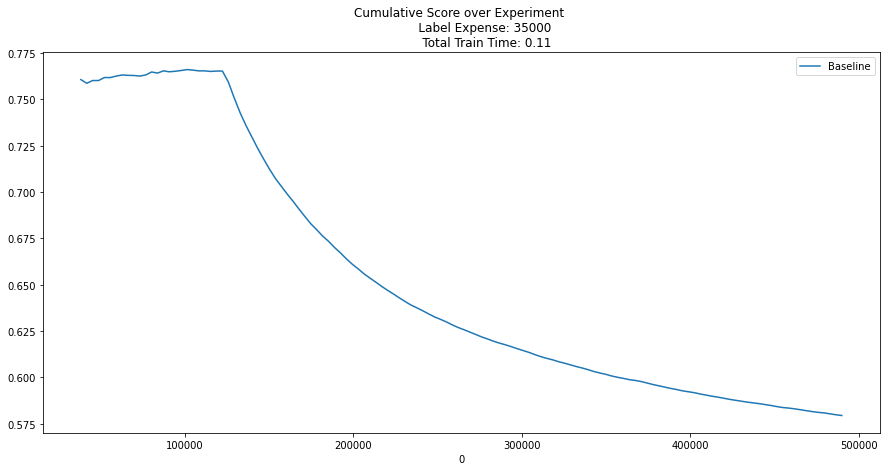

<IPython.core.display.Javascript object>

In [7]:
plot_experiment_error(baseline)

### Uncertainty KS Debug

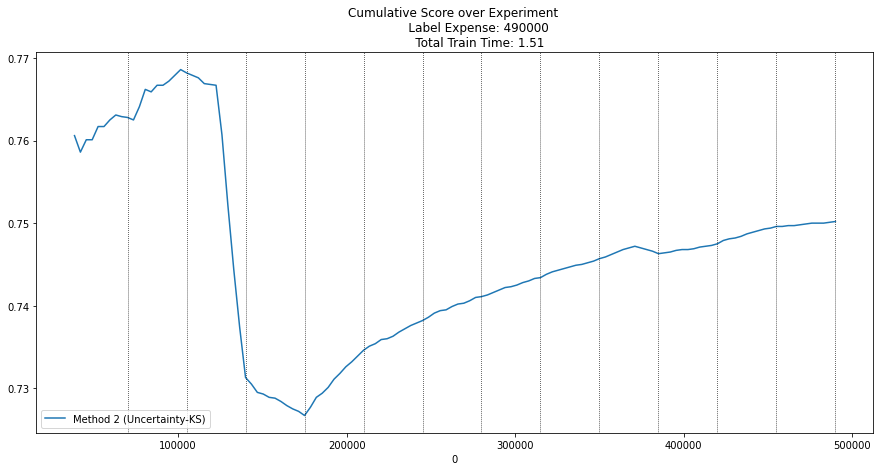

<IPython.core.display.Javascript object>

In [8]:
plot_experiment_error(uncertainty_ks)

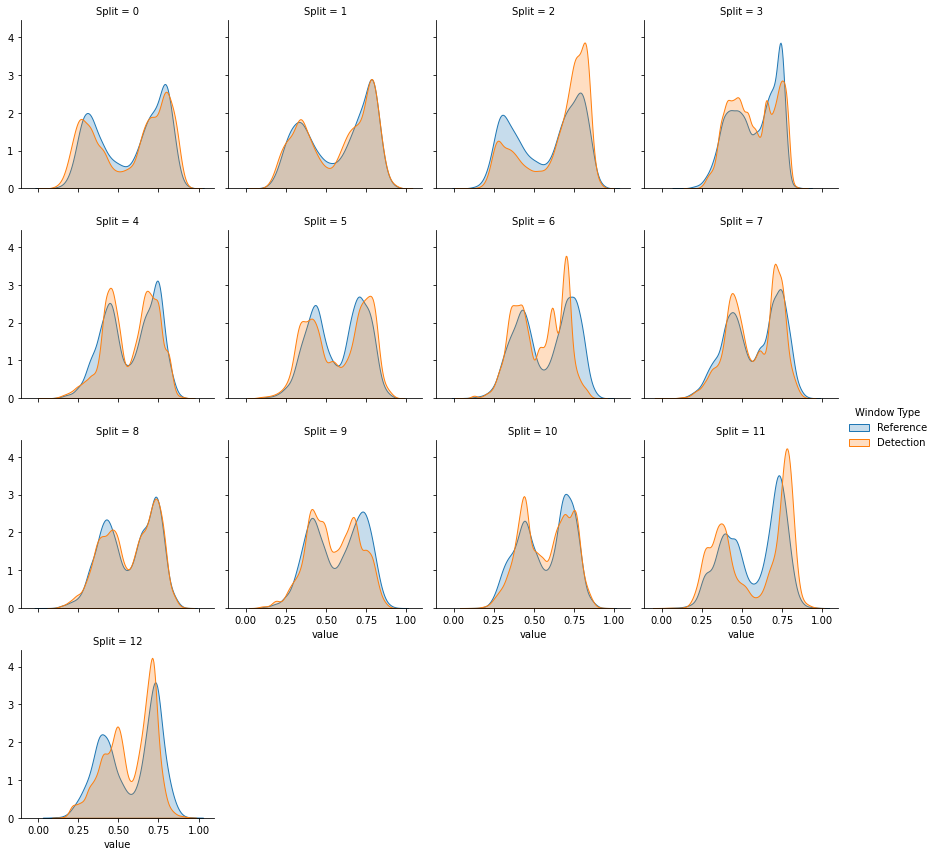

<IPython.core.display.Javascript object>

In [9]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: False
Expected Distribution: [0.9336, 0.0664]
Observed Distribution: [0.9536857142857142, 0.04631428571428572]
Percent change in margin: 0.3025
Number in Margin: Before 2324 | After 1621 | Difference 703
Chi-Square Results: Power_divergenceResult(statistic=227.77900068876315, pvalue=1.818509239916743e-51)

Same Distribution: False
Expected Distribution: [0.9271142857142857, 0.07288571428571429]
Observed Distribution: [0.9425714285714286, 0.057428571428571426]
Percent change in margin: 0.2121
Number in Margin: Before 2551 | After 2010 | Difference 541
Chi-Square Results: Power_divergenceResult(statistic=123.75159311299453, pvalue=9.547869430704045e-29)

Same Distribution: False
Expected Distribution: [0.9250285714285714, 0.07497142857142858]
Observed Distribution: [0.952, 0.048]
Percent change in margin: 0.3598
Number in Margin: Before 2624 | After 1680 | Difference 944
Chi-Square Results: Power_divergenceResult(statistic=367.13434221073123, pvalue=7.873051724600469e-

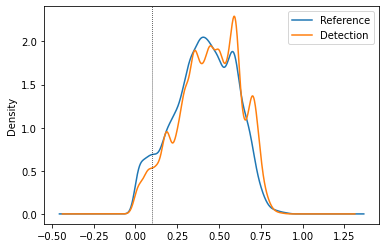

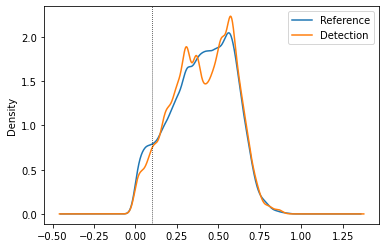

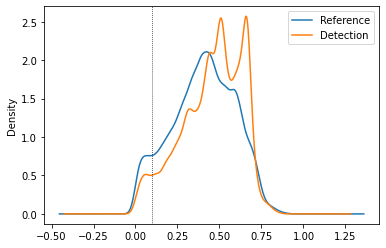

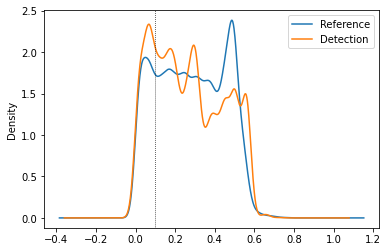

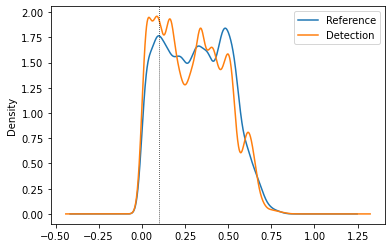

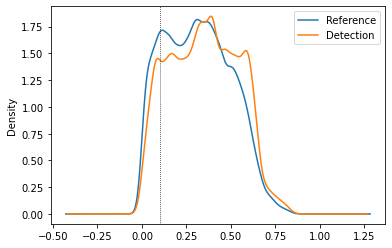

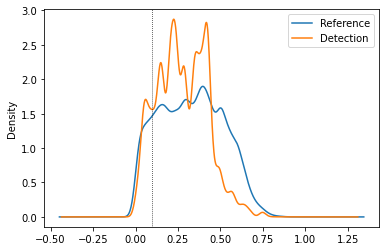

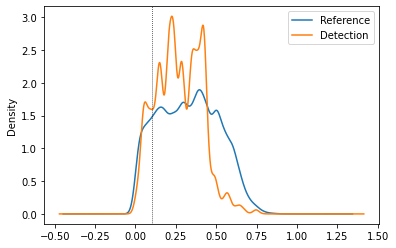

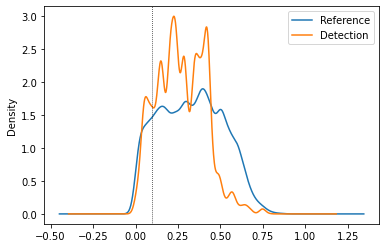

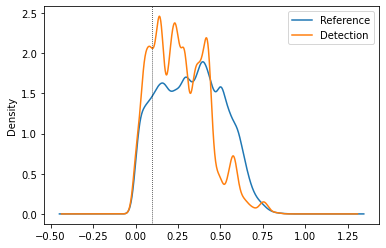

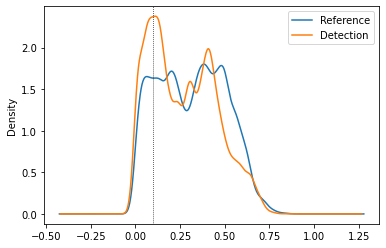

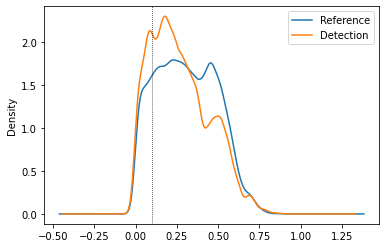

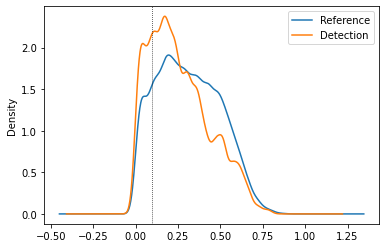

<IPython.core.display.Javascript object>

In [10]:
plot_margin_distributions_bysplit(uncertainty_x2)